# Find 3 Disks
Given an image with a background texture, and three overlaid texured disks, predict the centerpoint of the labeled “most concpicuous disk.”

In [12]:
import gc
import PIL
import math
import time
import random
import numpy as np
from os import listdir
from os.path import join

import os.path

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# Import DiskFind utilities for PredatorEye.
import sys
sys.path.append('/content/drive/My Drive/PredatorEye/shared_code/')
import DiskFind as df

df.set_global_random_seed(20220108)
model_save_directory = '/content/drive/My Drive/PredatorEye/saved_models/'

TensorFlow version: 2.7.0


# Define uniform texture dataset

In [13]:
# def MakeUniformTextureDataset(dataset_size, image_size, image_depth):
def make_uniform_dataset(dataset_size, image_size, image_depth):
    dataset_shape = (dataset_size, image_size, image_size, image_depth)
    images = []
    labels = []
    for i in tqdm(range(dataset_size)):
        # (image, label) = generateUniformExample(image_size, image_depth)
        (image, label) = generate_uniform_example(image_size, image_depth)
        images.append(image)
        labels.append(label)
        # # TODO TEMP -- Draw image for debugging
        # if ((i % 50) == 0) and (i < (50 * 5)): df.draw_image(image)
    return (images, labels)

# blah blah
# return an image (pixel tensor) and a label as (x, y) tensor
# def generateUniformExample(image_size, image_depth):
def generate_uniform_example(image_size, image_depth):
    bg_color = np.random.random_sample(image_depth)
    fg_color = np.random.random_sample(image_depth)
    disk_radius = image_size * df.relative_disk_radius()
    image_shape = (image_size, image_size, image_depth)
    image = np.full(image_shape, bg_color, dtype=np.float32)

    # Find 3 non-overlapping disk positions inside image.
    def random_center():
        s = image_size - (2 * disk_radius)
        return (np.random.random_sample(2) * s) + disk_radius
    centers = [random_center()]
    min_dist = 3 * disk_radius
    while len(centers) < 3:
        c = random_center()
        all_ok = True
        for o in centers:
            if (df.dist2d(c, o) < min_dist):
                all_ok = False
        if (all_ok):
            centers.append(c)

    # Draw soft-eged disk with given centerpoint and color.
    def draw_disk(center, color):
        cx = int(center[0])
        cy = int(center[1])
        dr = int(disk_radius)
        for x in range(cx - dr, cx + dr + 1):
            for y in range(cy - dr, cy + dr + 1):
                d = math.sqrt(math.pow(x - cx, 2) + math.pow(y - cy, 2))
                if (d <= dr):
                    blend = df.spot_utility((x, y), center, dr * 0.85, dr)
                    image[x, y, :] = df.interpolate(blend, bg_color, color) 

    # Draw 3 soft-edged disks, with colors progressively more like background.
    draw_disk(centers[0], fg_color)
    draw_disk(centers[1], df.interpolate(0.33, fg_color, bg_color))
    draw_disk(centers[2], df.interpolate(0.66, fg_color, bg_color))

    # return image
    # print('centers[0] =', centers[0])
    # print('type(centers[0]) =', type(centers[0]))
    label = centers[0] / image_size

    # TODO When I visualized the labels, they appeared xy flipped
    #      trying "unflipping them"
    label = np.array((label[1], label[0]))

    return (image, label)

# Reader for complex dataset

In [14]:
# Define complex texture (photo plus synthetic) dataset

# 20220130 this structure (copied from above) is wrong.
# We want to read the dir in the main function.
# the "per filename" function could later be expanded to do amplification
# if so, should return lists, which would need to be concatenated in caller.

# temp for prototyping
directory_pathname = '/content/drive/My Drive/PredatorEye/f3d_training_set/'

# def make_complex_dataset(dataset_size, image_size):
def make_complex_dataset():
    directory_contents = listdir(directory_pathname)

    # size_limit = 100
    # print('Limit complex dataset size to', size_limit)
    # directory_contents = directory_contents[0:size_limit]

    images = []
    labels = []
    for filename in tqdm(directory_contents):
        # image_pathname = join(directory_pathname, filename)
        image_pathname = os.path.join(directory_pathname, filename)
        (image, label) = make_complex_example(image_pathname)
        images.append(image)
        labels.append(label)
    return (images, labels)

def make_complex_example(image_pathname):
    # Read image file.
    image = PIL.Image.open(image_pathname)
    # Convert to numpy pixel tensor as 32 bit floats.
    pixels = np.asarray(image, dtype=np.float32)
    # Scale input image data to range [0, 1]
    # TODO try the experiment of using range [-1, 1] as was used in DLAVA
    pixels = np.interp(pixels, [0, 255], [0, 1]).astype(np.float32)
    # Parse disk center position from file name.
    filename = os.path.basename(image_pathname)
    center_position = df.fcd_normalized_xy(filename, pixels)
    return (pixels, center_position)

# # make_complex_example()
# (i, p) = make_complex_dataset()
# print('len(i) =', len(i))
# print('i[0].dtype =', i[0].dtype)
# print('i[0].shape =', i[0].shape)
# print('type(i) =', type(i))
# print('p[0] =', p[0])

# Generate dataset

In [15]:
df.reset_random_seeds()
start_time = time.time()

# (dataset_images,
#  dataset_labels) = make_uniform_dataset(dataset_size = 5000,
#                                         image_size = 128,
#                                         image_depth = 3) # RGB

(dataset_images, dataset_labels) = make_complex_dataset()

elapsed_seconds = int(time.time() - start_time)
print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
      str(int(elapsed_seconds / 60)) +' minutes).')

  0%|          | 0/20000 [00:00<?, ?it/s]

Elapsed time: 51 seconds (0 minutes).


# Split dataset

In [16]:
(images_train, images_test,
 labels_train, labels_test) = train_test_split(dataset_images,
                                               dataset_labels,
                                               test_size=0.2)
 
# Convert from Python lists to np arrays.
images_train = np.array(images_train, dtype=np.float32)
labels_train = np.array(labels_train, dtype=np.float32)
images_test = np.array(images_test, dtype=np.float32)
labels_test = np.array(labels_test, dtype=np.float32)

# Visualize some labels

2950


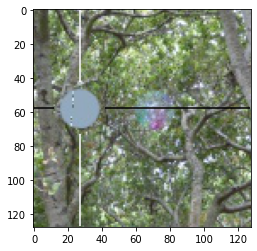

408


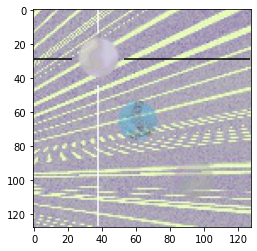

2592


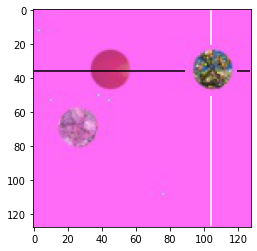

2413


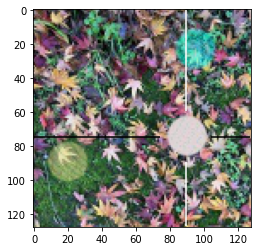

937


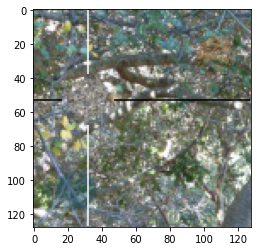

3118


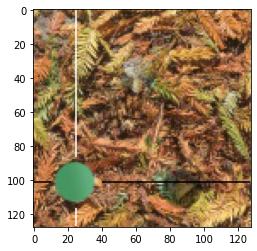

1034


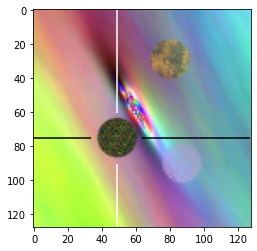

3171


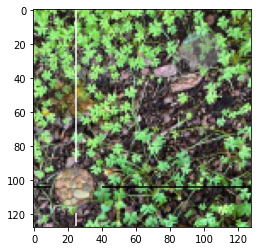

2482


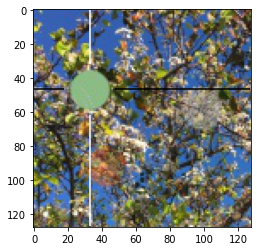

2110


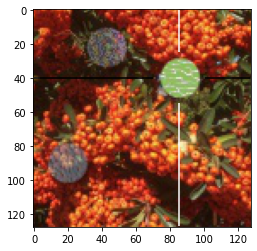

In [17]:
df.reset_random_seeds()
df.visualize_dataset(images = images_test, labels=labels_test)

# Build and train model

Epoch 1/100
125/125 [==============================] - 18s 125ms/step - loss: 0.3427 - accuracy: 0.4935 - in_disk: 0.0593 - val_loss: 0.0603 - val_accuracy: 0.5110 - val_in_disk: 0.0653
Epoch 2/100
125/125 [==============================] - 15s 117ms/step - loss: 0.0449 - accuracy: 0.5053 - in_disk: 0.0602 - val_loss: 0.0620 - val_accuracy: 0.5110 - val_in_disk: 0.0642
Epoch 3/100
125/125 [==============================] - 15s 117ms/step - loss: 0.0438 - accuracy: 0.4983 - in_disk: 0.0613 - val_loss: 0.0578 - val_accuracy: 0.4890 - val_in_disk: 0.0635
Epoch 4/100
125/125 [==============================] - 15s 116ms/step - loss: 0.0430 - accuracy: 0.4957 - in_disk: 0.0598 - val_loss: 0.0569 - val_accuracy: 0.5110 - val_in_disk: 0.0637
Epoch 5/100
125/125 [==============================] - 15s 117ms/step - loss: 0.0430 - accuracy: 0.5070 - in_disk: 0.0622 - val_loss: 0.0562 - val_accuracy: 0.5107 - val_in_disk: 0.0620
Epoch 6/100
125/125 [==============================] - 15s 117ms/step 

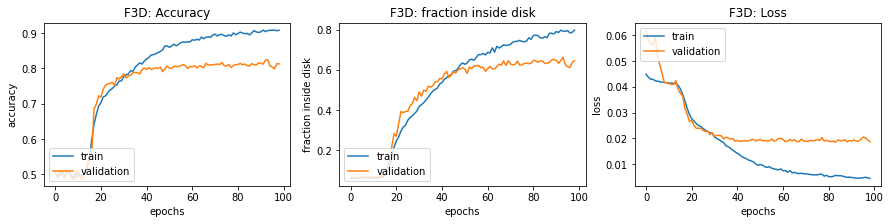

Elapsed time: 1463 seconds (24 minutes).
INFO:tensorflow:Assets written to: /content/drive/My Drive/PredatorEye/saved_models/20220201_1623_Find_3_Disks_complex/assets
Saved trained model to /content/drive/My Drive/PredatorEye/saved_models/20220201_1623_Find_3_Disks_complex


In [18]:
# Run a model.
df.reset_random_seeds()
start_time = time.time()
fcd_model_timestamp = df.timestamp_string()
(model, history) = ([], [])  # To release memory when rerunning in notebook.
gc.collect()

model = df.make_disk_finder_model(images_train)
history = df.run_model(model,
                       images_train, labels_train, images_test, labels_test,
                       epochs=100,
                       batch_size= 128,
                       plot_title='F3D')

elapsed_seconds = int(time.time() - start_time)
print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
      str(int(elapsed_seconds / 60)) +' minutes).')

# model.save(model_save_directory + fcd_model_timestamp)
model_save_path = (model_save_directory +
                   fcd_model_timestamp +
                   '_Find_3_Disks_complex')
model.save(model_save_path)
print('Saved trained model to', model_save_path)

In [19]:
print(type(history))
print(type(history.history['loss']))
print(len(history.history['loss']))
print(history.history['loss'])

<class 'keras.callbacks.History'>
<class 'list'>
100
[0.3426940441131592, 0.04489294812083244, 0.04377713426947594, 0.04299522191286087, 0.042953010648489, 0.04240062087774277, 0.04220501333475113, 0.04205528274178505, 0.04182541370391846, 0.041723910719156265, 0.041574422270059586, 0.041511327028274536, 0.04149433225393295, 0.041416946798563004, 0.041298091411590576, 0.04065556824207306, 0.03922375664114952, 0.03719961643218994, 0.03451986238360405, 0.031625762581825256, 0.02927221730351448, 0.027633974328637123, 0.02671584114432335, 0.025756817311048508, 0.024968517944216728, 0.024628199636936188, 0.023826964199543, 0.02317230962216854, 0.02261134795844555, 0.022227229550480843, 0.02190416306257248, 0.02047387883067131, 0.019974565133452415, 0.019450699910521507, 0.018895553424954414, 0.018356282263994217, 0.017123820260167122, 0.01676529087126255, 0.016131751239299774, 0.015437709167599678, 0.01478260476142168, 0.014224156737327576, 0.013663209974765778, 0.012914508581161499, 0.0124

# Visualize some predictions

2950


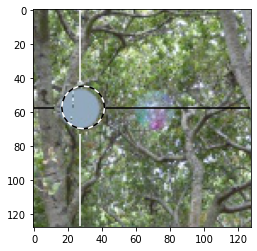

408


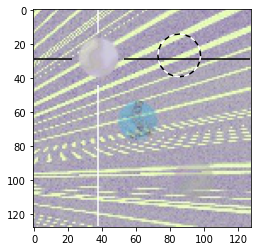

2592


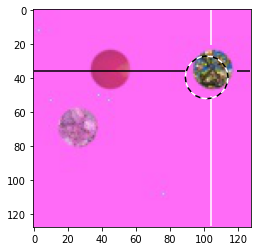

2413


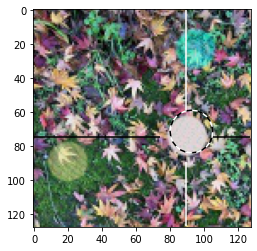

937


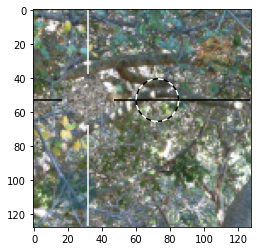

3118


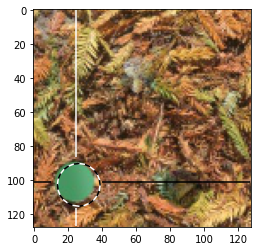

1034


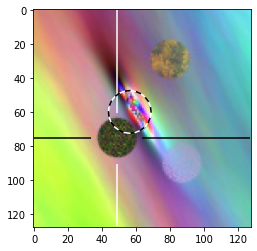

3171


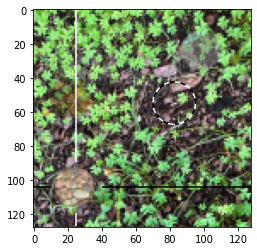

2482


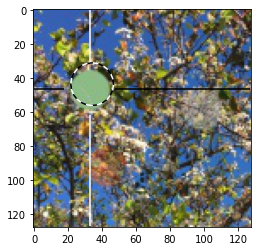

2110


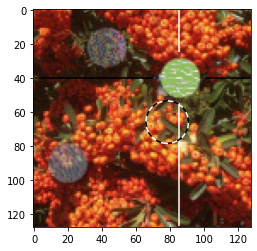

In [20]:
df.reset_random_seeds()
df.visualize_dataset(images=images_test, labels=labels_test, model=model)

test_image.shape = (128, 128, 3)
test_image.dtype = float32


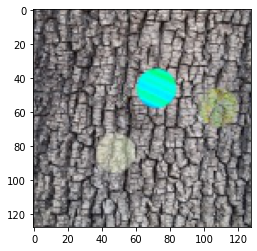

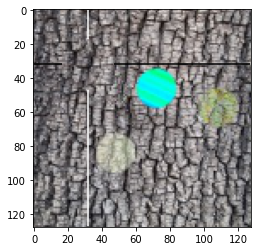

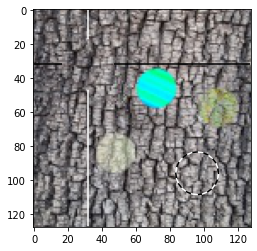

In [21]:

    # ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## just for testing
    # # Prototyping some changes to these functions in DiskFind.py

    # from PIL import Image
    # import matplotlib.pyplot as plt

    # # Relative disk size (diameter) and radius.
    # fcd_relative_disk_size = 201.0 / 1024.0
    # ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## just for testing


    # ################################################################################
    # # Draw utilities
    # ################################################################################

    # # Draw a training image on the log. First arg is either a 24 bit RGB pixel
    # # representation as read from file, or the rescaled 3xfloat used internally.
    # # Optionally draw crosshairs to show center of disk.
    # def draw_image(rgb_pixel_tensor, label=None, prediction=None):
    #     i24bit = []
    #     if ((rgb_pixel_tensor.dtype == np.float32) or
    #         (rgb_pixel_tensor.dtype == np.float64)):
    #         unscaled_pixels = np.interp(rgb_pixel_tensor, [0, 1], [0, 255])
    #         i24bit = Image.fromarray(unscaled_pixels.astype('uint8'), mode='RGB')
    #     else:
    #         i24bit = Image.fromarray(rgb_pixel_tensor)
    #     plt.imshow(i24bit)
    #     image_width = rgb_pixel_tensor.shape[0]
    #     disk_width = image_width * fcd_relative_disk_size
    #     if label is not None:
    #         # width = rgb_pixel_tensor.shape[0]
    #         # draw_crosshairs(center, width, width * fcd_relative_disk_size)
    #         # draw_crosshairs(label, width, width * fcd_relative_disk_size)
    #         draw_crosshairs(label, image_width, disk_width)
    #     if prediction is not None:
    #         prediction = np.array(prediction) * image_width
    #         draw_circle(prediction, disk_width)
    #     plt.show()

    # # Draw crosshairs to indicate disk position (label or estimate).
    # def draw_crosshairs(center, image_size, disk_size):
    #     m = image_size - 1       # max image coordinate
    #     s = disk_size * 1.2 / 2  # gap size (radius)
    #     h = center[0] * m        # center x in pixels
    #     v = center[1] * m        # center y in pixels
    #     plt.hlines(v, 0, max(0, h - s), color="black")
    #     plt.hlines(v, min(m, h + s), m, color="black")
    #     plt.vlines(h, 0, max(0, v - s), color="white")
    #     plt.vlines(h, min(m, v + s), m, color="white")

    # # Draw line in plot between arbitrary points in plot. (Not currently used.)
    # # eg: draw_line((100, 100), (924, 924), color="yellow")
    # #     (See https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html
    # #      for another approach)
    # def draw_line(p1, p2, color="white"):
    #     plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color)

    # # Draw a circle, dashed black and white, with given xy "center" and "diameter"
    # # both specified in pixel units.
    # def draw_circle(center, diameter):
    #     center = np.array(center)
    #     r = diameter / 2
    #     color = 'black'
    #     prev_angle = 0
    #     steps = 24
    #     for i in range(steps):
    #         next_angle = (i + 1) * 2 * math.pi / steps
    #         prev_point = np.array((math.sin(prev_angle), math.cos(prev_angle)))
    #         next_point = np.array((math.sin(next_angle), math.cos(next_angle)))
    #         draw_line(center + prev_point * r, center + next_point * r, color)
    #         if color == 'black':
    #             color = 'white'
    #         else:
    #             color = 'black'
    #         prev_angle = next_angle

            




    # ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## just for testing

    # # draw_circle((0,0), 0)

    # test_image = images_test[0]

    # print('test_image.shape =', test_image.shape)
    # print('test_image.dtype =', test_image.dtype)

    # draw_image(test_image)
    # draw_image(test_image, (0.25, 0.25))
    # draw_image(test_image, (0.25, 0.25), (0.75, 0.75))

    # ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## just for testing